In [3]:
from circuitEmbedding import *
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans 


# Create data:

from qtn_sim import *

In [4]:
def getSparsity(statevector):
    return (np.count_nonzero(statevector)/len(statevector))

def sparsityEstimator(tensors):

    if len(tensors) == 1:
        return np.count_nonzero(tensors[0].ravel())/len(tensors[0].ravel())
    
    tensorsLeft = tensors[:int(len(tensors)/2)]
    tensorsRight = tensors[int(len(tensors)/2):]
    
    return 1 - np.square(1-sparsityEstimator(tensorsLeft)*sparsityEstimator(tensorsRight))



In [5]:
numberOfQubits = 15
maxCircuitDepth = 100
numberOfCircuits = 750
bd = 10
filePath = "circuits75015100.json"

In [6]:
# Create data
circuitsCreated = createCircuits(numberOfCircuits, numberOfQubits, maxCircuitDepth, filePath)

circuitsRead = readCircuits(filePath)

In [7]:
# GET THE DATA
sparsity = []
sparsityE = []
circuitEmbeddings = []

circuitsRead = [GHZCircuit(numberOfQubits), QFTCircuit(numberOfQubits)] + circuitsRead

circuitIndex = 0

for circuit in circuitsRead:
    qSimulator = QuantumMPS(numberOfQubits,bd, SequentialOptimiser(swapping=True))
    qSimulator.applyCircuit(circuit)
    sparsity.append(getSparsity(qSimulator.get_state_vector()))
    e = sparsityEstimator(qSimulator.tensors)
    sparsityE.append(e)

In [8]:
# SAVE THE DATA
dims = int(75)

circuitEmbeddings = embedCircuits(circuitsRead, dims)

data = [circuitEmbeddings[i].tolist() + [sparsity[i], sparsityE[i]] for i in range(len(circuitEmbeddings))]

data = pd.DataFrame(np.array(data))

data.to_csv('sparsity.csv', index=False)

(752, 512)
[0.14899861 0.21523602 0.25119363 0.28343562 0.31450278 0.34021994
 0.36467062 0.38691367 0.40720259 0.42730003 0.4448305  0.46125027
 0.47685373 0.49205141 0.50548907 0.51831239 0.53081908 0.54285589
 0.55366245 0.5641839  0.57424449 0.58361411 0.59284274 0.6019084
 0.61022513 0.6183163  0.62593912 0.63345394 0.64079478 0.64781421
 0.65412143 0.66035286 0.66641468 0.67227175 0.67805365 0.68372108
 0.68920275 0.69458236 0.69981921 0.70483828 0.7096931  0.71453553
 0.71924896 0.72393552 0.72847262 0.73285852 0.73720498 0.74136762
 0.74548282 0.74956434 0.75351819 0.7574122  0.76126485 0.76507553
 0.76881372 0.77244735 0.77606853 0.77962988 0.78310741 0.78643004
 0.78969274 0.79286041 0.79597623 0.79907423 0.80208901 0.80506242
 0.80802753 0.81088078 0.81371423 0.81647894 0.81916829 0.82182984
 0.82448936 0.82707256 0.82963666]


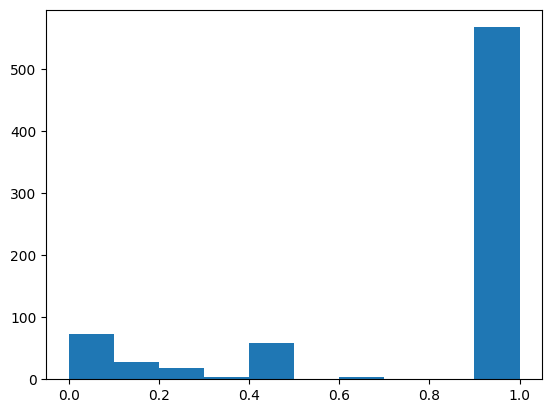

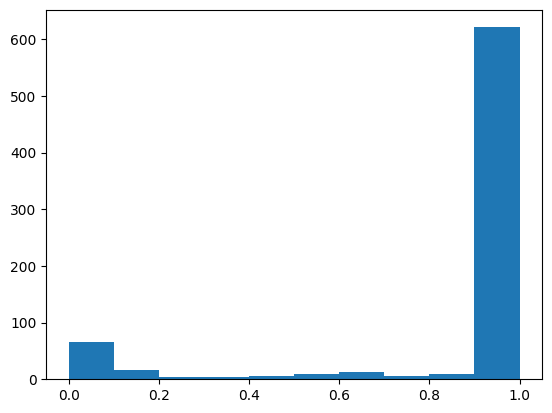

In [10]:
# LOAD THE DATA
data = pd.read_csv('sparsity.csv')

# Data distribution

plt.hist(data[str(dims)])
plt.show()
plt.hist(data[str(dims+1)])
plt.show()

Average + difference.
Sparse circuits actual & est.
Different levels of sparsity performance est. Diff over regions.



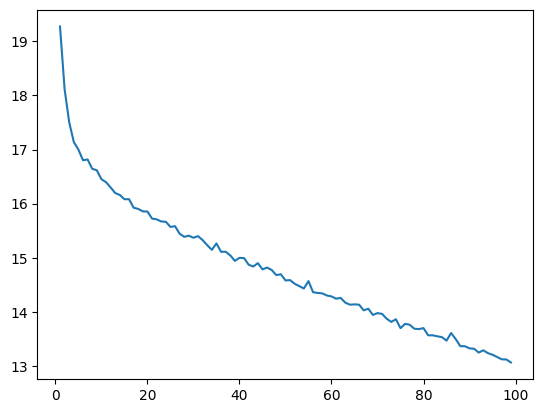

In [11]:
# Choose 3 bins for the sparsity, so 3 clusters

# Clustering
X = data[:-2]

# Xs = (X - np.mean(X,axis = 0))/np.std(X, axis = 0)
Xs = X
inertia = []
K = 100
distortions = [] 
for k in range(1,K):
    km = KMeans(n_clusters=k, max_iter=10000)
    km = km.fit(Xs)
    inertia.append(km.inertia_)
    distortions.append(sum(np.min(cdist(X,km.cluster_centers_, 'euclidean'),axis=1))/Xs.shape[0])

plt.plot([i for i in range(1,K)], distortions)
plt.show()


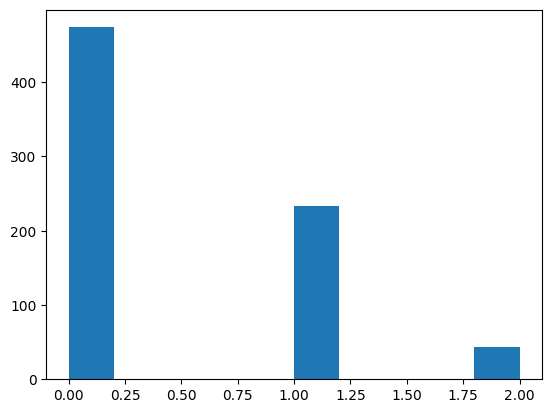

In [21]:
k = 3

km = KMeans(n_clusters=k, max_iter=10000)
# km = km.fit(X)

label = km.fit_predict(data[:-1])

plt.hist(label)

plt.show()



Gate occurence: Notes.